PART 1:


In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg11
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
torch.cuda.empty_cache()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


model = vgg11(pretrained=True)

model.classifier[6] = nn.Linear(4096, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)


Files already downloaded and verified
Files already downloaded and verified


d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

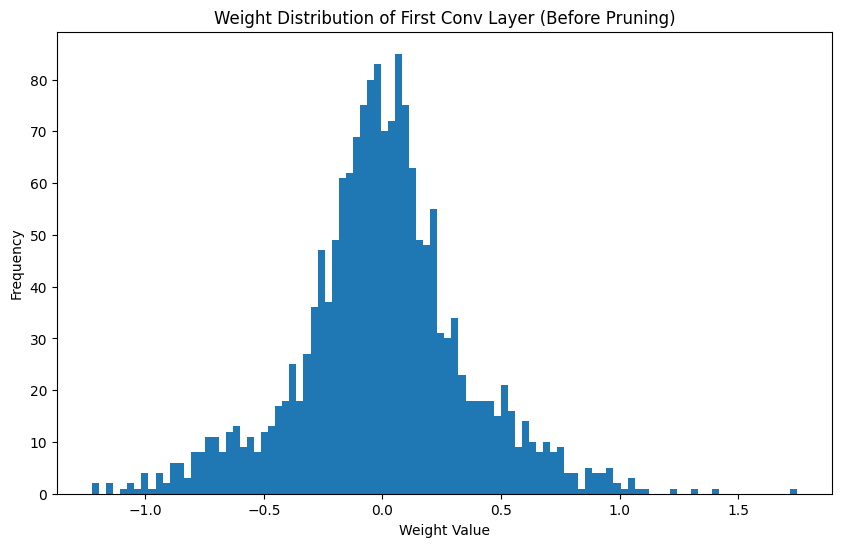

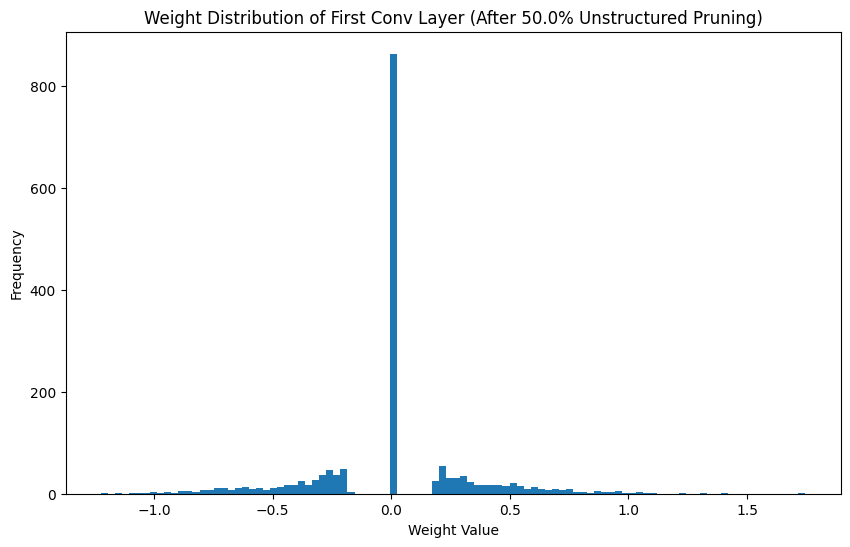

Applied and visualized unstructured pruning with a sparsity of 50.0%.


In [ ]:
def unstructured_prune(module, sparsity_ratio):
    
    if hasattr(module, 'weight'):
        weight = module.weight.data.clone()
        flat_weight = weight.flatten()
        num_prune = int(len(flat_weight) * sparsity_ratio)
        threshold = torch.kthvalue(torch.abs(flat_weight), num_prune).values
        mask = torch.abs(weight) > threshold
        module.weight.data *= mask.float()

def plot_weight_distribution(weight_tensor, title):
   
    plt.figure(figsize=(10, 6))
    plt.hist(weight_tensor.flatten().cpu().numpy(), bins=100)
    plt.title(title)
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.show()


layer_to_inspect = model.features[0] 


original_weights = layer_to_inspect.weight.data.clone()
plot_weight_distribution(original_weights, "Weight Distribution of First Conv Layer (Before Pruning)")

sparsity = 0.5 
unstructured_prune(layer_to_inspect, sparsity_ratio=sparsity)
pruned_weights = layer_to_inspect.weight.data.clone()


plot_weight_distribution(pruned_weights, f"Weight Distribution of First Conv Layer (After {sparsity*100}% Unstructured Pruning)")

layer_to_inspect.weight.data = original_weights

print(f"Applied and visualized unstructured pruning with a sparsity of {sparsity*100}%.")

In [ ]:
import torch.optim as optim
import torch.nn as nn
import os
torch.cuda.empty_cache()
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg11
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import copy


def evaluate_model(model, testloader):
  
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def plot_weight_distribution(weight_tensor, title):
   
    plt.figure(figsize=(10, 6))
    plt.hist(weight_tensor.flatten().cpu().numpy(), bins=100)
    plt.title(title)
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.show()



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the base VGG model
model = vgg11(pretrained=True)
model.classifier[6] = nn.Linear(4096, 10)
model.to(device)

print("Initial setup and helper functions are defined.")



tuned_model_path = 'vgg11_cifar10_finetuned.pth'


if os.path.exists(tuned_model_path):
    print(f"Loading existing fine-tuned model from '{tuned_model_path}'...")
  
    model = vgg11()
    model.classifier[6] = nn.Linear(4096, 10)
    model.load_state_dict(torch.load(tuned_model_path))
    model.to(device)
    print("Model loaded.")
else:
    print(f"No fine-tuned model found. Starting the fine-tuning process...")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    num_epochs = 5 

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.3f}")

    print('Finished Fine-Tuning.')
    

    torch.save(model.state_dict(), tuned_model_path)
    print(f"Fine-tuned model saved to '{tuned_model_path}'")



baseline_accuracy = evaluate_model(model, testloader)
print(f'\nAccuracy of the fine-tuned baseline model on the test images: {baseline_accuracy:.2f} %')



Files already downloaded and verified
Files already downloaded and verified
Using device: cuda
Initial setup and helper functions are defined.
Loading existing fine-tuned model from 'vgg11_cifar10_finetuned.pth'...


C:\Users\xylic\AppData\Local\Temp\ipykernel_27052\738923552.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tuned_model_path))


Model loaded.

Accuracy of the fine-tuned baseline model on the test images: 84.61 %


PART 2:

Loading cached sensitivity results from 'unstructured_sensitivity_results.pth'...
Results loaded successfully.
Plotting the sensitivity analysis graph...


C:\Users\xylic\AppData\Local\Temp\ipykernel_27052\280325674.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sensitivity_results = torch.load(results_filename)


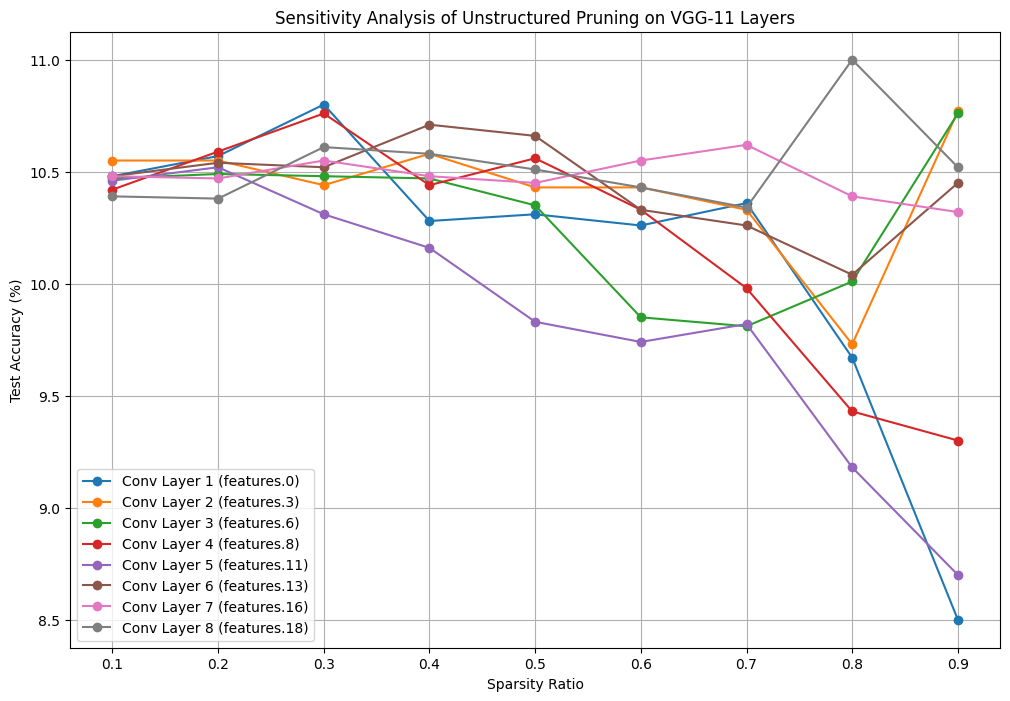

In [ ]:
import copy
torch.cuda.empty_cache()
def evaluate_model(model, testloader):
    
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total




import os
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


results_filename = 'unstructured_sensitivity_results.pth'


if os.path.exists(results_filename):
    print(f"Loading cached sensitivity results from '{results_filename}'...")
    sensitivity_results = torch.load(results_filename)
  
    sparsity_ratios = np.linspace(0.1, 0.9, 9) 
    print("Results loaded successfully.")

else:
    print(f"Cached results not found. Running the full sensitivity analysis...")
    
 
    conv_layers = [module for module in model.features if isinstance(module, nn.Conv2d)]
    layer_indices = [i for i, module in enumerate(model.features) if isinstance(module, nn.Conv2d)]
    sparsity_ratios = np.linspace(0.1, 0.9, 9)
    sensitivity_results = {}


    for i, layer_idx in enumerate(tqdm(layer_indices, desc="Pruning Layers")):
        layer_accuracies = []
        
      
        for sparsity in sparsity_ratios:
       
            model_copy = copy.deepcopy(model)
            model_copy.to(device)
            
      
            layer_to_prune = model_copy.features[layer_idx]
            
         
            unstructured_prune(layer_to_prune, sparsity_ratio=sparsity)
            
       
            accuracy = evaluate_model(model_copy, testloader)
            layer_accuracies.append(accuracy)
            
        sensitivity_results[f'Conv Layer {i+1} (features.{layer_idx})'] = layer_accuracies
    # -------------------------------------------------------------------------

    print("Sensitivity analysis complete.")
    
 
    print(f"Saving sensitivity results to '{results_filename}'...")
    torch.save(sensitivity_results, results_filename)
    print("Results saved.")
.

print("Plotting the sensitivity analysis graph...")
plt.figure(figsize=(12, 8))
for layer_name, accuracies in sensitivity_results.items():
    plt.plot(sparsity_ratios, accuracies, marker='o', linestyle='-', label=layer_name)

plt.title('Sensitivity Analysis of Unstructured Pruning on VGG-11 Layers')
plt.xlabel('Sparsity Ratio')
plt.ylabel('Test Accuracy (%)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

PART 3:

In [ ]:
import torch.nn.utils.prune as prune
torch.cuda.empty_cache()
def calculate_overall_sparsity(model):
   
    total_params = 0
    total_zero_params = 0
    
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            total_params += module.weight.nelement()
            total_zero_params += torch.sum(module.weight == 0)
            
    sparsity = 100. * float(total_zero_params) / float(total_params)
    return sparsity


unstructured_pruned_model = copy.deepcopy(model)
unstructured_pruned_model.to(device)


modules_to_prune = []
for name, module in unstructured_pruned_model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        modules_to_prune.append(module)

s
sparsity_per_layer = [
   
    0.80, 0.80, 
    0.75, 0.75, 
    0.70, 0.70, 
    0.60, 0.60,
  
    0.75, 0.75, 0.70
]

print("Applying layer-wise unstructured pruning...")


for i, module in enumerate(modules_to_prune):
 
    prune.l1_unstructured(module, name="weight", amount=sparsity_per_layer[i])
    prune.remove(module, 'weight')

print("Pruning applied.")

final_sparsity = calculate_overall_sparsity(unstructured_pruned_model)
print(f"Final Overall Sparsity: {final_sparsity:.2f}%")

final_accuracy = evaluate_model(unstructured_pruned_model, testloader)
print(f"Accuracy of Unstructured Pruned Model: {final_accuracy:.2f}%")

torch.save(unstructured_pruned_model.state_dict(), 'unstructured_pruned_vgg11.pth')
print("Unstructured pruned model saved to 'unstructured_pruned_vgg11.pth'")

Applying layer-wise unstructured pruning...


Pruning applied.
Final Overall Sparsity: 74.31%
Accuracy of Unstructured Pruned Model: 32.42%
Unstructured pruned model saved to 'unstructured_pruned_vgg11.pth'


STRUCTURED PRUNING:  
PART 1:


Plotting weight distribution before pruning...


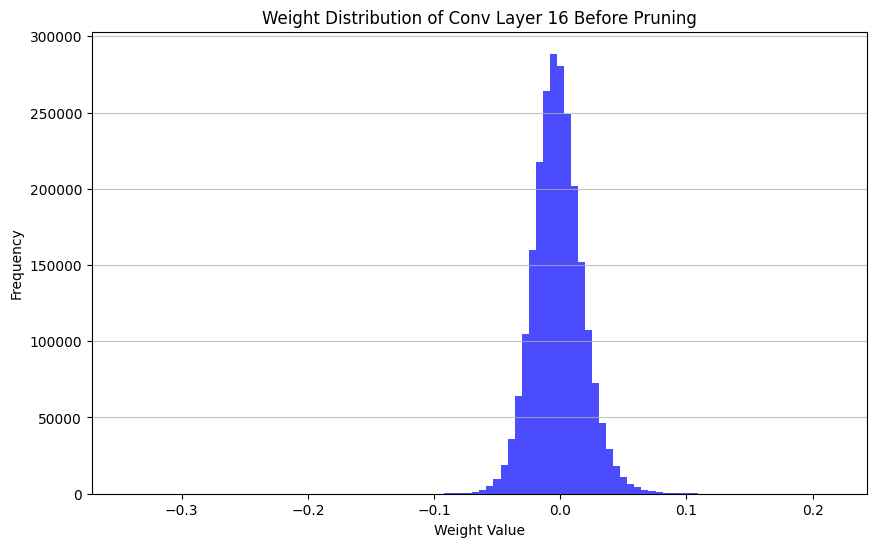

Plotting weight distribution after 50% pruning...


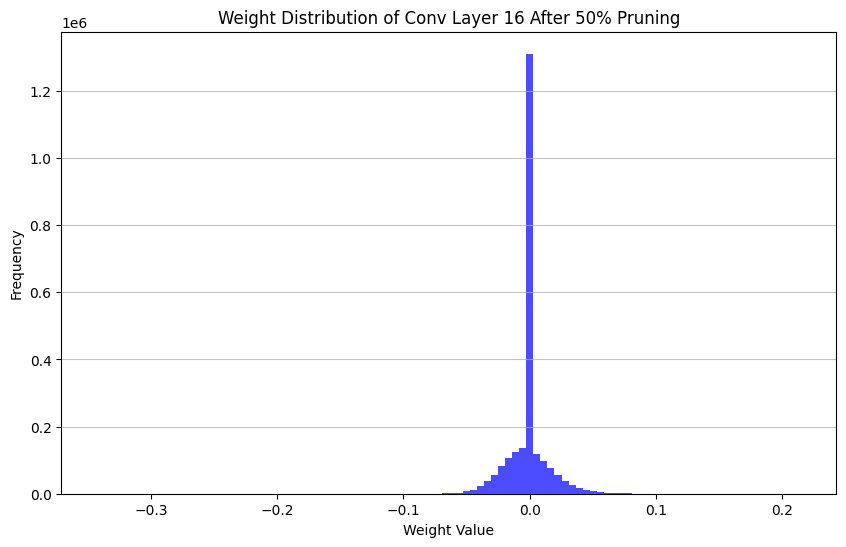

In [ ]:


def plot_weight_distribution(model, layer_index, title):
  
    layer = model.features[layer_index]
    weights = layer.weight.data.cpu().numpy().flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(weights, bins=100, alpha=0.7, color='blue')
    plt.title(title)
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()


CHOSEN_LAYER_IDX = 16


print("\nPlotting weight distribution before pruning...")
plot_weight_distribution(model, CHOSEN_LAYER_IDX, f"Weight Distribution of Conv Layer {CHOSEN_LAYER_IDX} Before Pruning")


temp_pruned_model = copy.deepcopy(model)


layer_to_prune = temp_pruned_model.features[CHOSEN_LAYER_IDX]
l1_norms = torch.sum(torch.abs(layer_to_prune.weight.data), dim=(1, 2, 3))
threshold = torch.quantile(l1_norms, 0.5)
mask_to_keep = l1_norms >= threshold
layer_to_prune.weight.data *= mask_to_keep.view(-1, 1, 1, 1).float()

# 3. Plot weight distribution AFTER pruning
print("Plotting weight distribution after 50% pruning...")
plot_weight_distribution(temp_pruned_model, CHOSEN_LAYER_IDX, f"Weight Distribution of Conv Layer {CHOSEN_LAYER_IDX} After 50% Pruning")

PART 2:


Starting sensitivity analysis. This may take a few minutes...
Layer 0, Sparsity 0.1: Accuracy Drop = 0.12%
Layer 0, Sparsity 0.2: Accuracy Drop = 0.63%
Layer 0, Sparsity 0.3: Accuracy Drop = 1.30%
Layer 0, Sparsity 0.4: Accuracy Drop = 2.03%
Layer 0, Sparsity 0.5: Accuracy Drop = 4.56%
Layer 0, Sparsity 0.6: Accuracy Drop = 26.31%
Layer 0, Sparsity 0.7: Accuracy Drop = 43.51%
Layer 0, Sparsity 0.8: Accuracy Drop = 55.57%
Layer 0, Sparsity 0.9: Accuracy Drop = 68.15%
Layer 3, Sparsity 0.1: Accuracy Drop = 0.47%
Layer 3, Sparsity 0.2: Accuracy Drop = 1.55%
Layer 3, Sparsity 0.3: Accuracy Drop = 3.19%
Layer 3, Sparsity 0.4: Accuracy Drop = 18.94%
Layer 3, Sparsity 0.5: Accuracy Drop = 27.49%
Layer 3, Sparsity 0.6: Accuracy Drop = 45.07%
Layer 3, Sparsity 0.7: Accuracy Drop = 56.11%
Layer 3, Sparsity 0.8: Accuracy Drop = 63.60%
Layer 3, Sparsity 0.9: Accuracy Drop = 71.22%
Layer 6, Sparsity 0.1: Accuracy Drop = 0.88%
Layer 6, Sparsity 0.2: Accuracy Drop = 1.41%
Layer 6, Sparsity 0.3: Accu

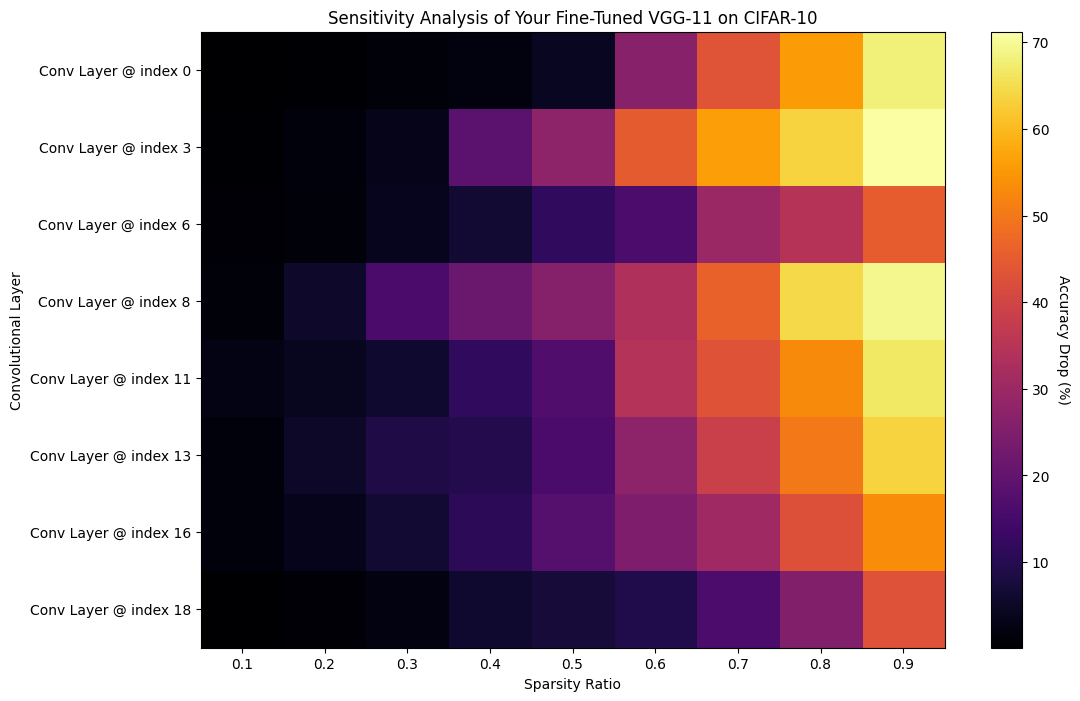

In [ ]:

conv_layer_indices = [i for i, layer in enumerate(model.features) if isinstance(layer, nn.Conv2d)]

def analyze_sensitivity(model, layer_idx, ratio):

    temp_model = copy.deepcopy(model)
    layer = temp_model.features[layer_idx]

    l1_norms = torch.sum(torch.abs(layer.weight.data), dim=(1, 2, 3))
    threshold = torch.quantile(l1_norms, ratio)
    mask_to_keep = l1_norms >= threshold

    layer.weight.data *= mask_to_keep.view(-1, 1, 1, 1).float()
    if layer.bias is not None:
        layer.bias.data *= mask_to_keep.float()

    accuracy = evaluate_model(temp_model, testloader)
    return baseline_accuracy - accuracy

print("\nStarting sensitivity analysis. This may take a few minutes...")
sparsity_ratios = np.linspace(0.1, 0.9, 9)
sensitivity_data = np.zeros((len(conv_layer_indices), len(sparsity_ratios)))

for i, layer_idx in enumerate(conv_layer_indices):
    for j, ratio in enumerate(sparsity_ratios):
        accuracy_drop = analyze_sensitivity(model, layer_idx, ratio)
        sensitivity_data[i, j] = accuracy_drop
        print(f"Layer {layer_idx}, Sparsity {ratio:.1f}: Accuracy Drop = {accuracy_drop:.2f}%")


plt.figure(figsize=(12, 8))
plt.imshow(sensitivity_data, cmap='inferno', interpolation='nearest', aspect='auto')
cbar = plt.colorbar()
cbar.set_label('Accuracy Drop (%)', rotation=270, labelpad=15)
plt.xticks(ticks=np.arange(len(sparsity_ratios)), labels=[f'{r:.1f}' for r in sparsity_ratios])
plt.yticks(ticks=np.arange(len(conv_layer_indices)), labels=[f'Conv Layer @ index {i}' for i in conv_layer_indices])
plt.xlabel("Sparsity Ratio")
plt.ylabel("Convolutional Layer")
plt.title("Sensitivity Analysis of Your Fine-Tuned VGG-11 on CIFAR-10")
plt.show()

PART 3:

In [10]:
torch.cuda.empty_cache()

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import copy
import os

def evaluate_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=0)


model_path = "vgg11_cifar10_finetuned.pth"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Error: The model file '{model_path}' was not found.")
    

finetuned_model = models.vgg11(pretrained=False)
finetuned_model.classifier[6] = nn.Linear(finetuned_model.classifier[6].in_features, 10)
finetuned_model.load_state_dict(torch.load(model_path))
finetuned_model = finetuned_model.to(device)
finetuned_model.eval()


def create_pruned_vgg_model(original_model, sparsity_per_layer):
    
    new_model = copy.deepcopy(original_model)
    conv_layer_indices = [i for i, module in enumerate(original_model.features) if isinstance(module, nn.Conv2d)]
    
    masks = {}

    for layer_idx in conv_layer_indices:
        layer = original_model.features[layer_idx]
        ratio = sparsity_per_layer.get(layer_idx, 0)
        l1_norms = torch.sum(torch.abs(layer.weight.data), dim=(1, 2, 3))
        num_to_keep = int(len(l1_norms) * (1 - ratio))
        indices_to_keep = torch.topk(l1_norms, num_to_keep, largest=True).indices
        masks[layer_idx] = sorted(indices_to_keep.tolist())

    new_features = []
    last_kept_channels_indices = None

    for i, layer in enumerate(original_model.features):
        if isinstance(layer, nn.Conv2d):
            kept_output_channels_indices = masks[i]
            in_channels = len(last_kept_channels_indices) if last_kept_channels_indices is not None else layer.in_channels
            out_channels = len(kept_output_channels_indices)
            new_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding)
            
            kept_weights = layer.weight.data[kept_output_channels_indices, :, :, :]
            kept_biases = layer.bias.data[kept_output_channels_indices]
            
            if last_kept_channels_indices is not None:
                kept_weights = kept_weights[:, last_kept_channels_indices, :, :]

            new_conv.weight.data = kept_weights
            new_conv.bias.data = kept_biases
            new_features.append(new_conv)
            last_kept_channels_indices = kept_output_channels_indices
    
        elif isinstance(layer, (nn.ReLU, nn.MaxPool2d)):
            new_features.append(copy.deepcopy(layer))

    new_model.features = nn.Sequential(*new_features)


    with torch.no_grad():
        dummy_input = torch.randn(1, 3, 32, 32).to(device)

        features_output = new_model.features(dummy_input)
        pooled_output = new_model.avgpool(features_output)
        classifier_input_size = pooled_output.view(1, -1).size(1)
    
    old_classifier = original_model.classifier
    

    new_classifier = nn.Sequential(
        nn.Linear(classifier_input_size, old_classifier[0].out_features),
        nn.ReLU(True),
        nn.Dropout(p=old_classifier[2].p),
        nn.Linear(old_classifier[3].in_features, old_classifier[3].out_features),
        nn.ReLU(True),
        nn.Dropout(p=old_classifier[5].p),
        nn.Linear(old_classifier[6].in_features, old_classifier[6].out_features)
    )
 

    new_model.classifier = new_classifier
    
    return new_model

print("\n--- Defining Final Pruning Strategy based on Sensitivity Analysis ---")
sparsity_per_layer = {
    0: 0.10, 3: 0.20, 6: 0.50, 8: 0.60, 11: 0.75, 13: 0.80, 16: 0.85, 18: 0.90,
}
print("Chosen Sparsity Ratios:", sparsity_per_layer)


final_pruned_model = create_pruned_vgg_model(finetuned_model, sparsity_per_layer).to(device)


total_params_original = sum(p.numel() for p in finetuned_model.parameters())
total_params_pruned = sum(p.numel() for p in final_pruned_model.parameters())
compression_ratio = (1 - (total_params_pruned / total_params_original)) * 100

print(f"\n--- Final Structured Pruned Model Results ---")
print(f"Total parameters in original model: {total_params_original:,}")
print(f"Total parameters in pruned model: {total_params_pruned:,}")
print(f"Achieved memory footprint compression: {compression_ratio:.2f}%")


print("\nEvaluating accuracy of the final structured pruned model...")
pruned_accuracy = evaluate_model(final_pruned_model, testloader, device)
original_accuracy = evaluate_model(finetuned_model, testloader, device)

print(f"Accuracy of the original fine-tuned model: {original_accuracy:.2f}%")
print(f"Accuracy after structured pruning (before fine-tuning): {pruned_accuracy:.2f}%")
print(f"Accuracy drop: {original_accuracy - pruned_accuracy:.2f}%")

final_model_path = "vgg11_cifar10_structured_pruned.pth"
torch.save(final_pruned_model.state_dict(), final_model_path)
print(f"\nFinal structured pruned model saved to: '{final_model_path}'")

Files already downloaded and verified


C:\Users\xylic\AppData\Local\Temp\ipykernel_31256\3782934540.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetuned_model.load_state_dict(torch.load(model_path))



--- Defining Final Pruning Strategy based on Sensitivity Analysis ---
Chosen Sparsity Ratios: {0: 0.1, 3: 0.2, 6: 0.5, 8: 0.6, 11: 0.75, 13: 0.8, 16: 0.85, 18: 0.9}

--- Final Structured Pruned Model Results ---
Total parameters in original model: 128,807,306
Total parameters in pruned model: 27,691,561
Achieved memory footprint compression: 78.50%

Evaluating accuracy of the final structured pruned model...
Accuracy of the original fine-tuned model: 84.61%
Accuracy after structured pruning (before fine-tuning): 10.25%
Accuracy drop: 74.36%

Final structured pruned model saved to: 'vgg11_cifar10_structured_pruned.pth'


In [6]:

from tqdm import tqdm
print("\n--- Starting Fine-Tuning of the Structured Pruned Model ---")



optimizer = torch.optim.SGD(final_pruned_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
num_finetune_epochs = 20 


trainloader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True, num_workers=0
)

for epoch in range(num_finetune_epochs):
    final_pruned_model.train() 
    running_loss = 0.0
    
    progress = tqdm(trainloader, desc=f"Fine-Tuning Epoch {epoch + 1}/{num_finetune_epochs}", leave=False)
    for inputs, labels in progress:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = final_pruned_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress.set_postfix(loss=f"{running_loss / len(progress):.4f}")
    
   
    current_accuracy = evaluate_model(final_pruned_model, testloader, device)
    print(f"Epoch {epoch + 1}, Fine-Tuned Accuracy: {current_accuracy:.2f}%")

print("\n--- Finished Fine-Tuning ---")

final_finetuned_accuracy = evaluate_model(final_pruned_model, testloader, device)
print(f"Original Model Accuracy: {original_accuracy:.2f}%")
print(f"Accuracy After Pruning (Before Fine-Tuning): {pruned_accuracy:.2f}%")
print(f"Final Accuracy After Fine-Tuning: {final_finetuned_accuracy:.2f}%")


finetuned_pruned_path = "vgg11_cifar10_structured_pruned_finetuned.pth"
torch.save(final_pruned_model.state_dict(), finetuned_pruned_path)
print(f"\nFinal fine-tuned pruned model saved to: '{finetuned_pruned_path}'")


--- Starting Fine-Tuning of the Structured Pruned Model ---
Files already downloaded and verified


Epoch 1, Fine-Tuned Accuracy: 46.56%


Epoch 2, Fine-Tuned Accuracy: 69.92%


Epoch 3, Fine-Tuned Accuracy: 75.88%


Epoch 4, Fine-Tuned Accuracy: 78.26%


Epoch 5, Fine-Tuned Accuracy: 78.65%


Epoch 6, Fine-Tuned Accuracy: 80.12%


Epoch 7, Fine-Tuned Accuracy: 80.18%


Epoch 8, Fine-Tuned Accuracy: 81.04%


Epoch 9, Fine-Tuned Accuracy: 80.72%


Epoch 10, Fine-Tuned Accuracy: 82.07%


Epoch 11, Fine-Tuned Accuracy: 82.16%


Epoch 12, Fine-Tuned Accuracy: 81.80%


KeyboardInterrupt: 